##### Attention: In order to run this notebook, one must have the "KITTI-Sequence" folder and the "ground_truth" file in the same directory as the notebook for question 1. Regarding question 2, one must have the ""post-processed" folder within the same directory, whcih contains 3 other folders: "marcelinho", "post-processed" and "test".

##### The comments provided along the code, as well as the markdown texts, were written in a way that each step was explained accordingly.

### Question 1

The main objective of this problem is to estimate the final trajectory of a vehicle, given that this trajectory starts from the first scan.

In [1]:
# We import the relevant libraries
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os

Load the ground truth data from a numpy file.

In [2]:
gt_path = 'ground_truth.npy'
ground_truth = np.load(gt_path)

In [3]:
# Let's check the ground truth shape
print("Loaded Grund Truth Shape:")
print(ground_truth.shape)

Loaded Grund Truth Shape:
(30, 4, 4)


We create an auxiliar function to load vertex positions from an OBJ file.

In [4]:
def load_obj(file_path):
    # Initialize an empty list to store vertex positions
    positions = []
    with open(file_path, 'r') as file:
        for line in file:
            # Split the line into tokens
            tokens = line.split()

            # Ignore empty lines and comments
            if not tokens or tokens[0] == '#':
                continue

            # Check for vertex data
            if tokens[0] == 'v':
                # Extract the vertex position
                position = [float(tokens[1]), float(tokens[2]), float(tokens[3])]
                positions.append(position)
    return np.array(positions)

We also create a function to find the closest points in a target point cloud for each point in a source point cloud

In [5]:
def find_closest_points(source, target):
    # Find the closest points in 'target' for each point in 'source'
    # Returns a list of indices, one for each point in 'source'
    closest_indices = []
    for s_point in source:
        distances = cdist([s_point], target)
        closest_index = np.argmin(distances)
        closest_indices.append(closest_index)
    return closest_indices

Now, it's time to implement the Iterative Closest Point (ICP) algorithm.

In [6]:
def icp(source, target, transform_number ,max_iterations=21, tolerance=1e-5):
    transformation = np.eye(4)  # Initialize a 4x4 identity matrix

    print(f"Performing transform of number: {transform_number}")
    for i in range(max_iterations):
        # Find closest points
        closest_indices = find_closest_points(source, target)
        matched_source = source
        matched_target = target[closest_indices]

        # Compute the centroid of each set of points
        centroid_source = np.mean(matched_source, axis=0)
        centroid_target = np.mean(matched_target, axis=0)

        # Compute the cross-covariance matrix
        cov_matrix = np.dot((matched_source - centroid_source).T, matched_target - centroid_target)

        # Perform Singular Value Decomposition (SVD)
        u, s, vh = np.linalg.svd(cov_matrix)

        # Calculate the rotation matrix and translation
        rotation = np.dot(vh.T, u.T)
        translation = centroid_target - np.dot(rotation, centroid_source)

        # Build the 4x4 transformation matrix
        transformation_new = np.eye(4)
        transformation_new[:3, :3] = rotation
        transformation_new[:3, 3] = translation

        # Update the source point cloud
        source = np.dot(source, transformation_new[:3, :3].T) + transformation_new[:3, 3]

        # Check for convergence
        delta_transformation = np.linalg.norm(transformation_new - transformation)
        if delta_transformation < tolerance:
            break

        transformation = transformation_new

        if i % 10 == 0:
          # Visualize the point clouds and the current transformation
          visualize_point_clouds(target, source, transformation, i)

    return transformation

# Function to visualize two point clouds and the current alignment transformation
def visualize_point_clouds(target_point_cloud, source_point_cloud, alignment_transformation, i):
    # Transform the source point cloud using the alignment transformation
    transformed_source_point_cloud = np.dot(source_point_cloud, alignment_transformation[:3, :3].T) + alignment_transformation[:3, 3]

    # Visualize the target point cloud in blue and the transformed source point cloud in red
    plt.scatter(target_point_cloud[:, 0], target_point_cloud[:, 1], c='blue', label='Target')
    plt.scatter(transformed_source_point_cloud[:, 0], transformed_source_point_cloud[:, 1], c='red', label='Transformed Source')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'ICP Point Cloud Alignment At Iteration {i+1}')
    plt.legend()
    plt.show()

The function below compares two transformation matrices using Frobenius norm, so we can have a evaluation metric.

In [7]:
def compare_transformations(estimated_matrix, ground_truth_matrix):
    # Compute the Frobenius norm of the difference between the two matrices
    frobenius_norm = np.linalg.norm(estimated_matrix - ground_truth_matrix)
    return frobenius_norm

In [8]:
# Generate file paths and load the point clouds
point_clouds = []
for i in range(30):
    file_path = os.path.join('', f"KITTI-Sequence/{i:06d}/{i:06d}_points.obj")
    point_cloud = load_obj(file_path)
    point_clouds.append(point_cloud)

Performing transform of number: 1


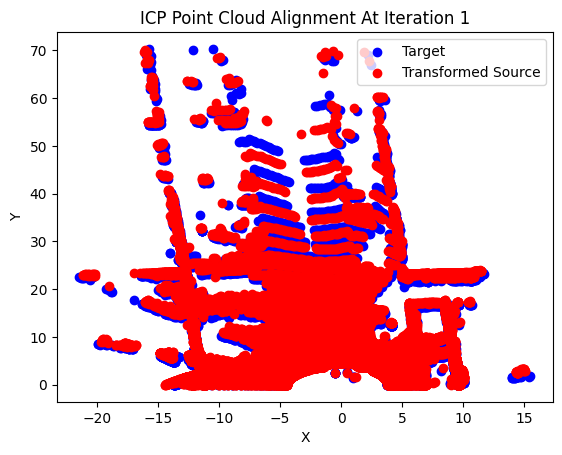

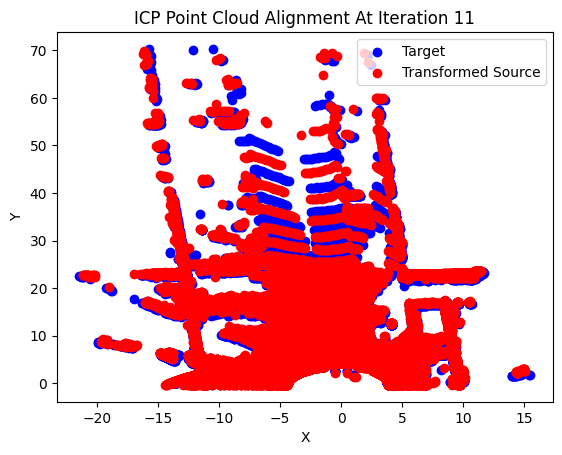

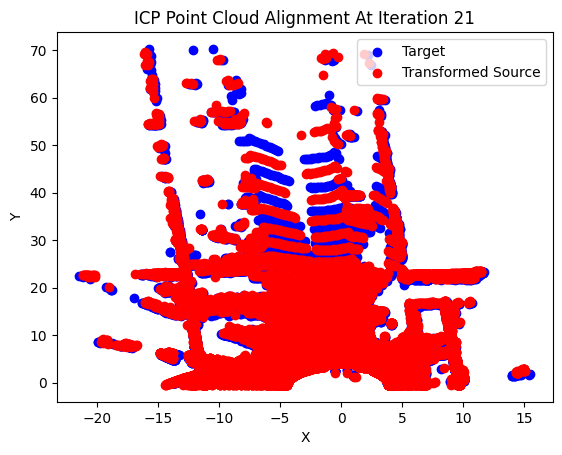

Frobenius Norm of the Difference: 0.0071347626227276865
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 2


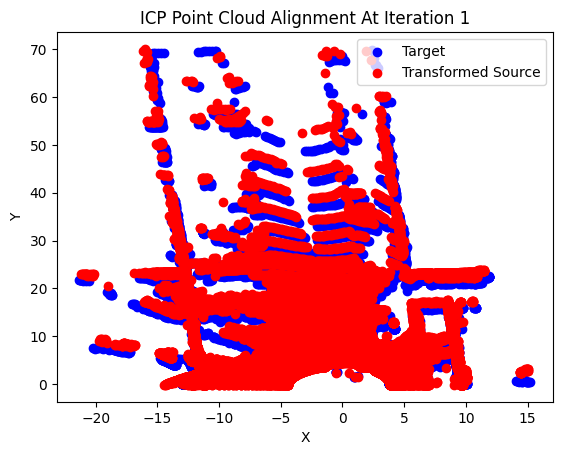

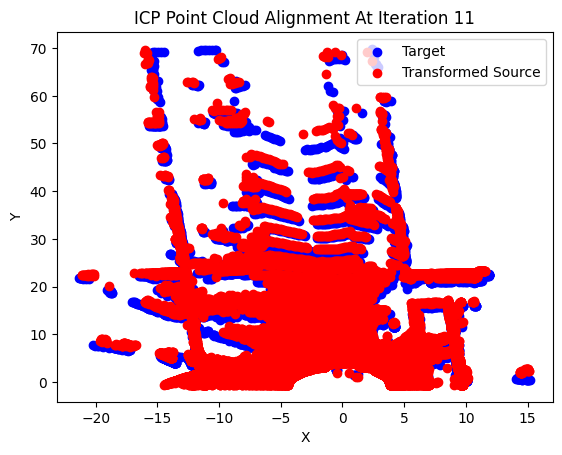

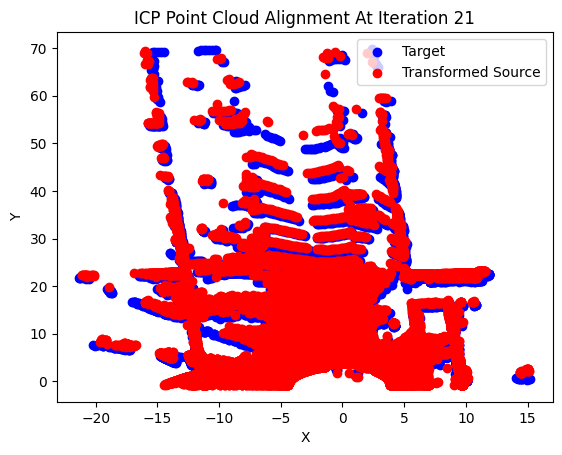

Frobenius Norm of the Difference: 0.859915544323655
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 3


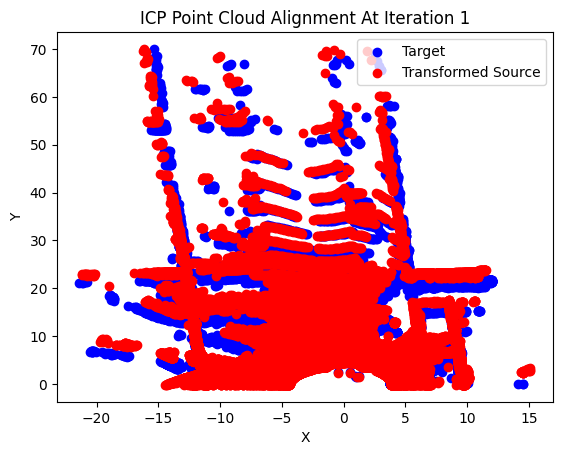

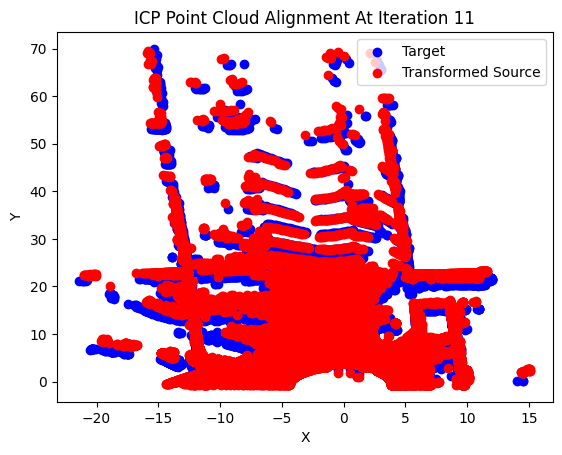

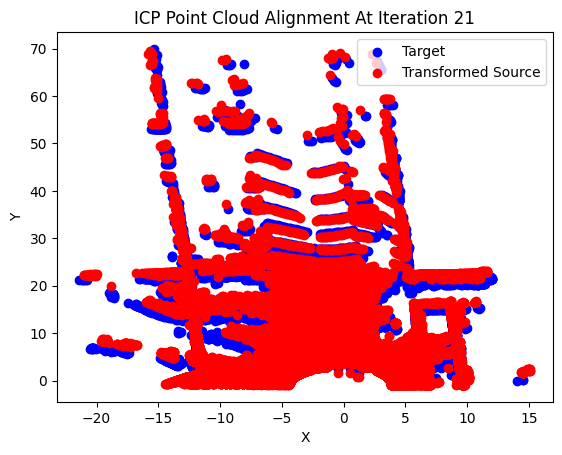

Frobenius Norm of the Difference: 1.719443620019793
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 4


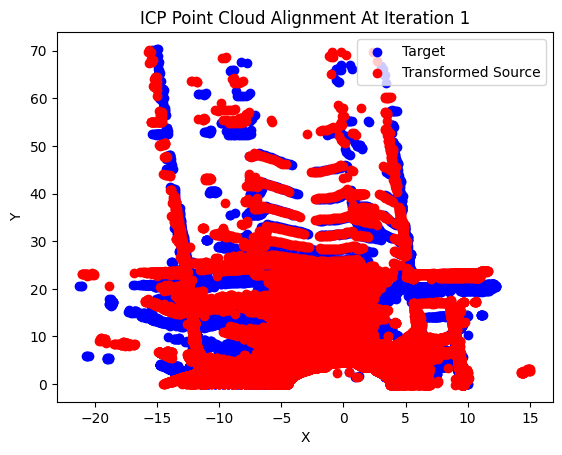

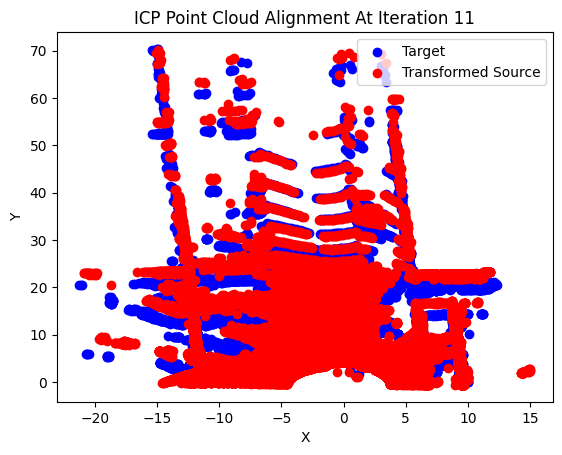

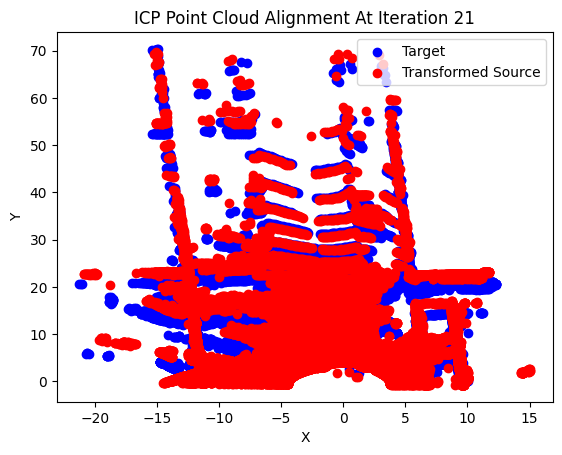

Frobenius Norm of the Difference: 2.5794836612086374
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 5


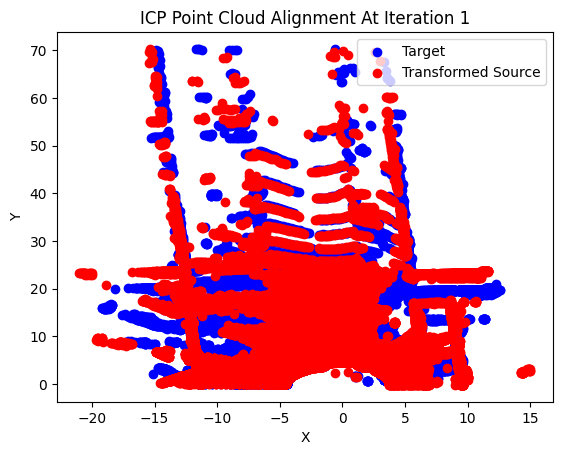

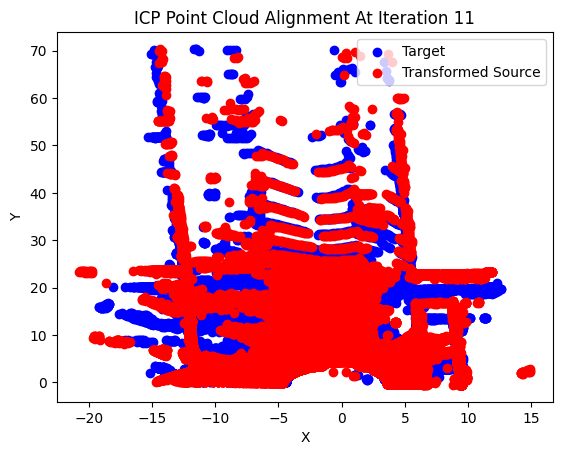

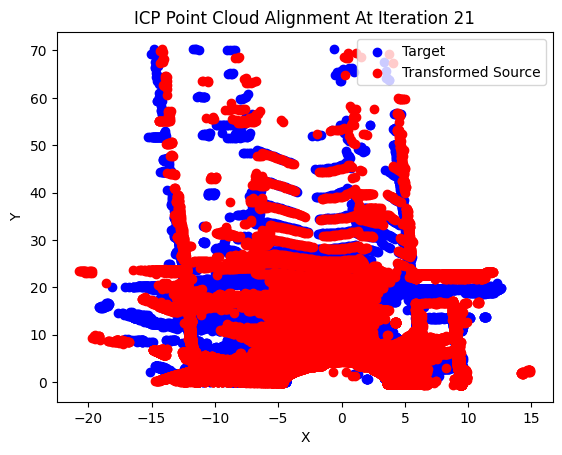

Frobenius Norm of the Difference: 3.439642670374767
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 6


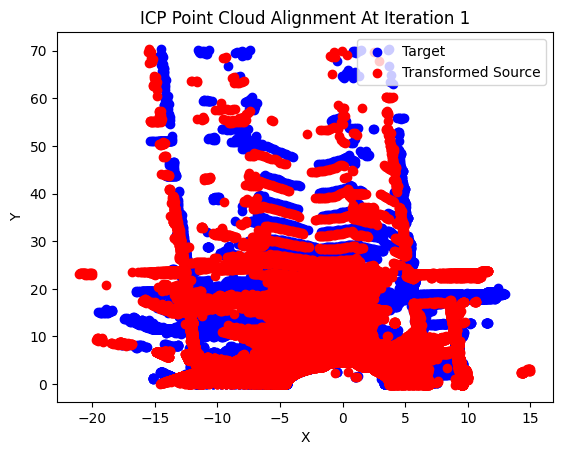

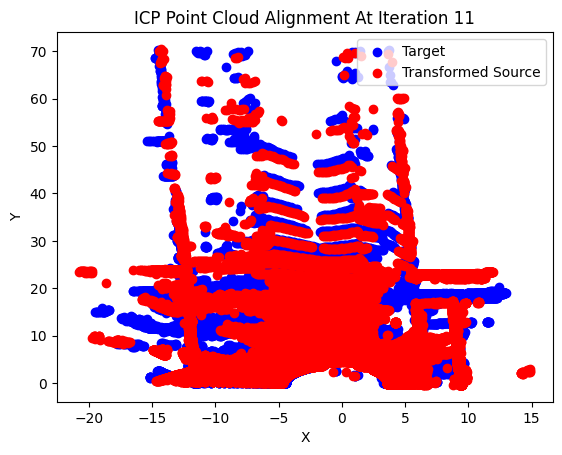

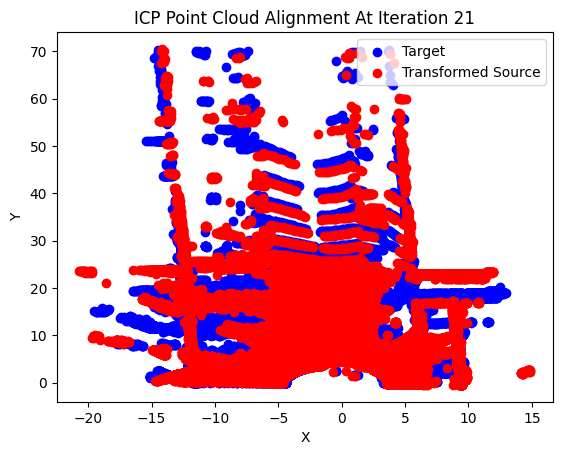

Frobenius Norm of the Difference: 4.299926122857132
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 7


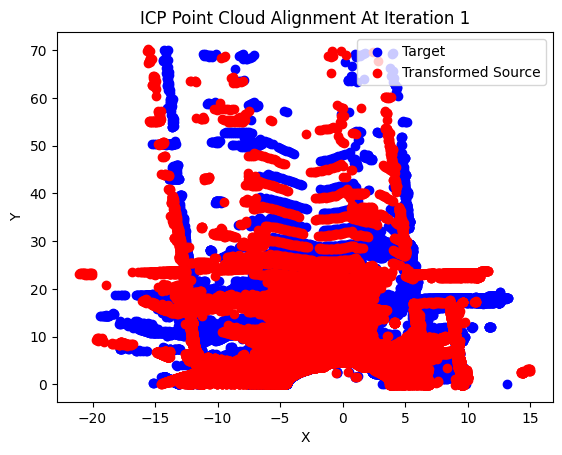

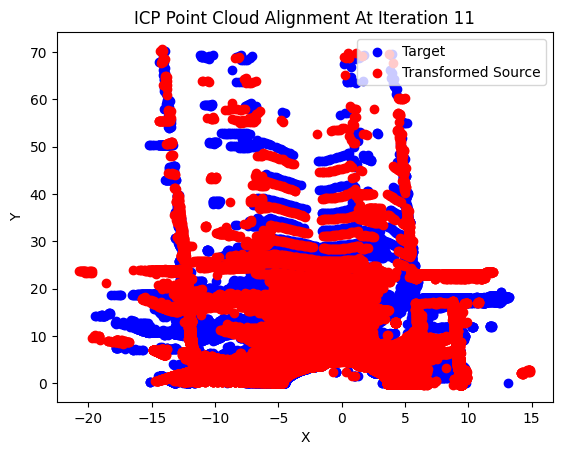

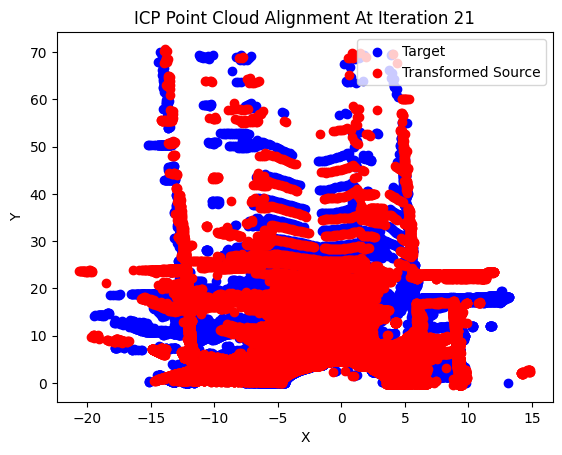

Frobenius Norm of the Difference: 5.159493860037448
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 8


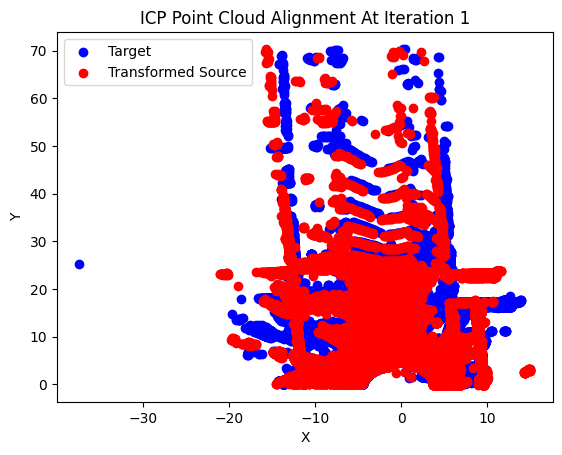

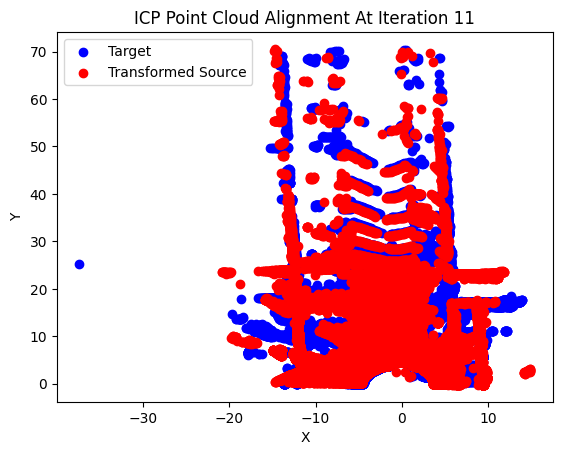

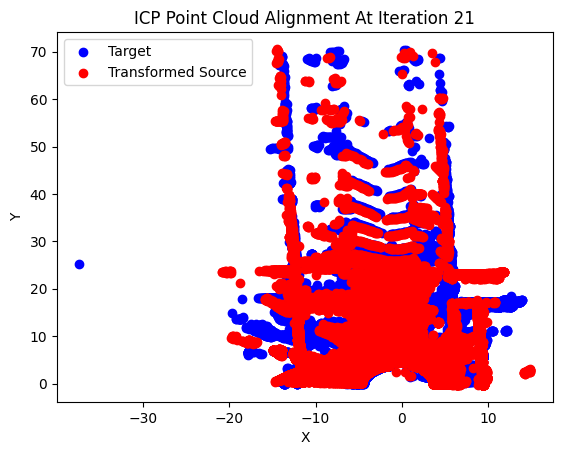

Frobenius Norm of the Difference: 6.019981268928123
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 9


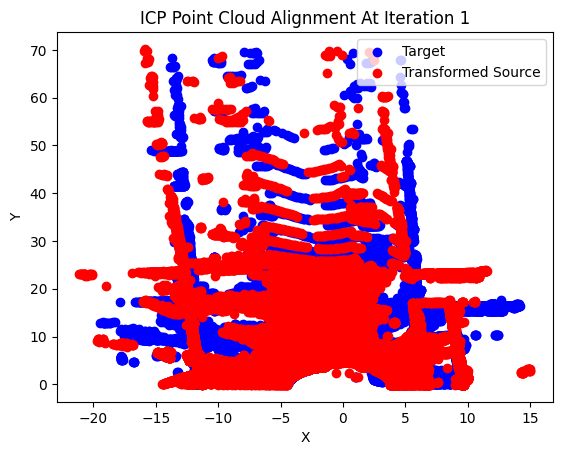

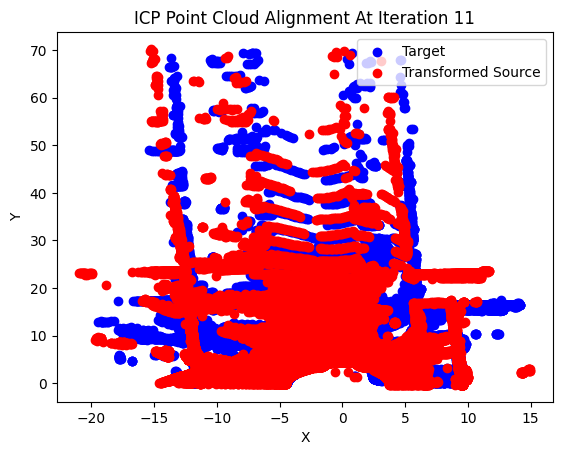

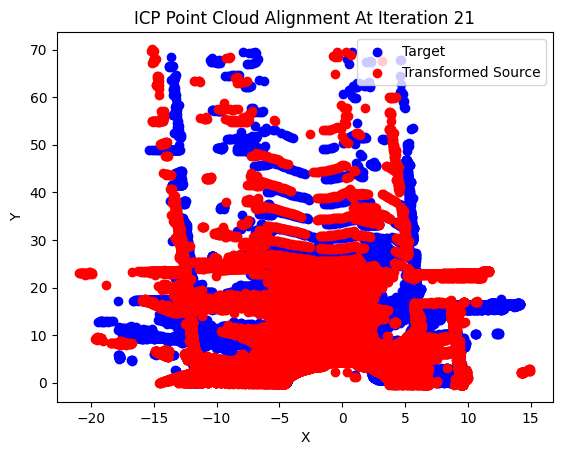

Frobenius Norm of the Difference: 6.879503159327262
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 10


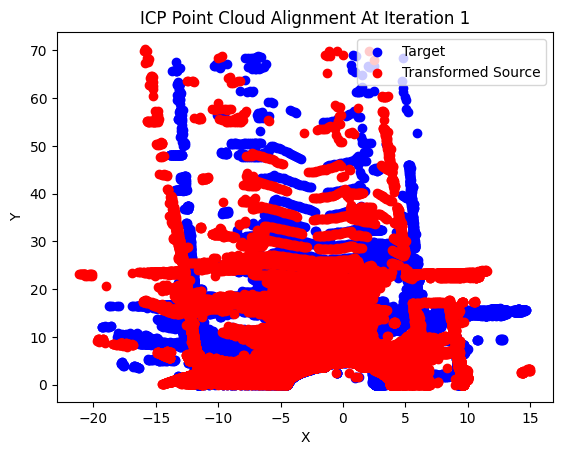

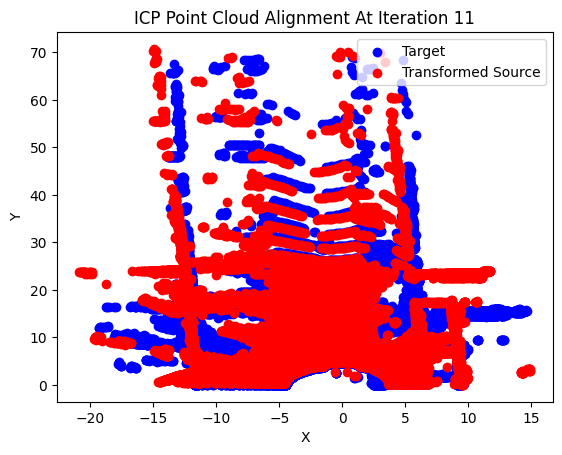

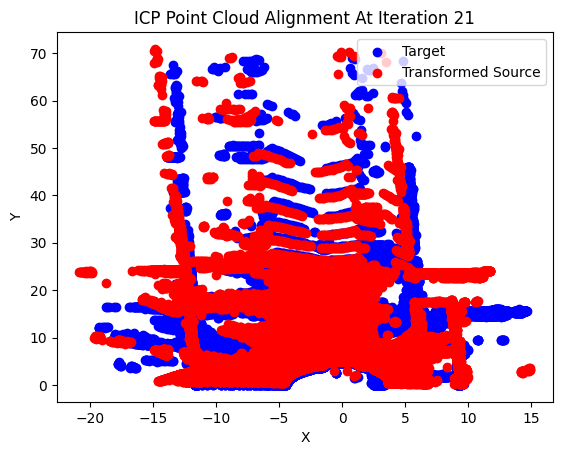

Frobenius Norm of the Difference: 7.740240070917576
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 11


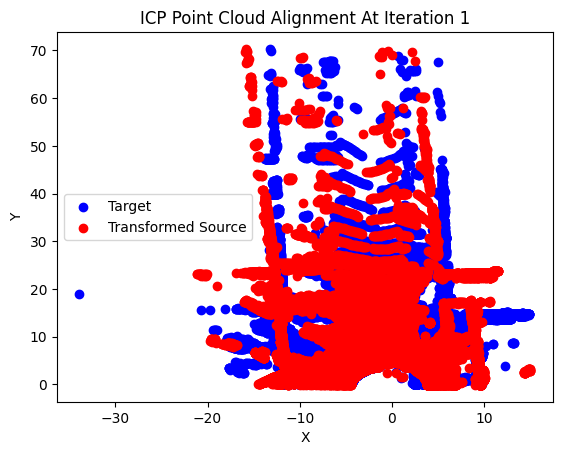

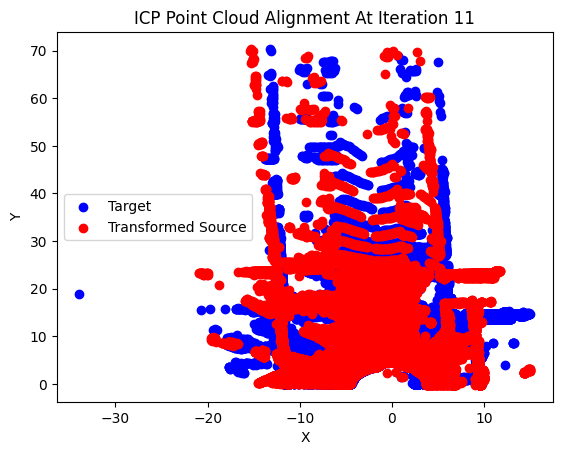

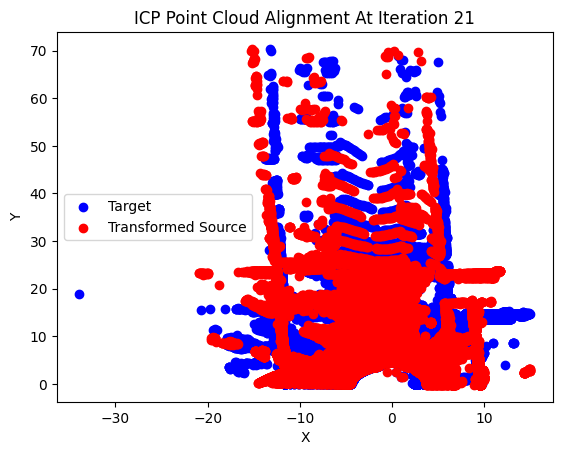

Frobenius Norm of the Difference: 8.60036662820385
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 12


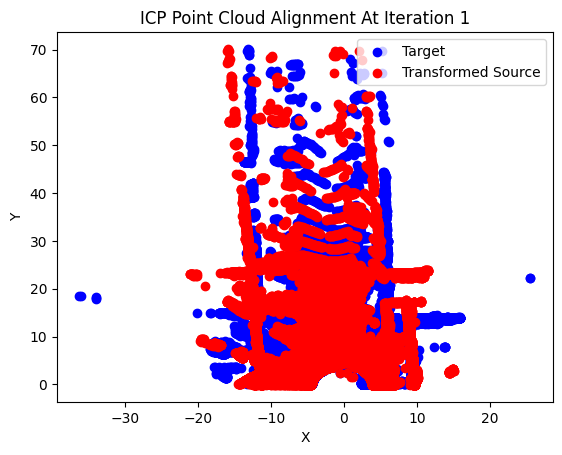

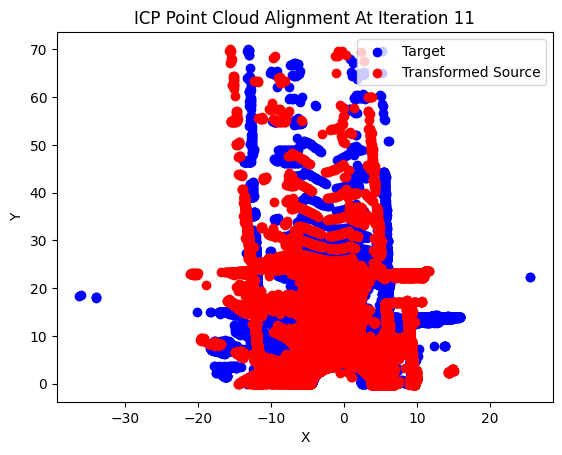

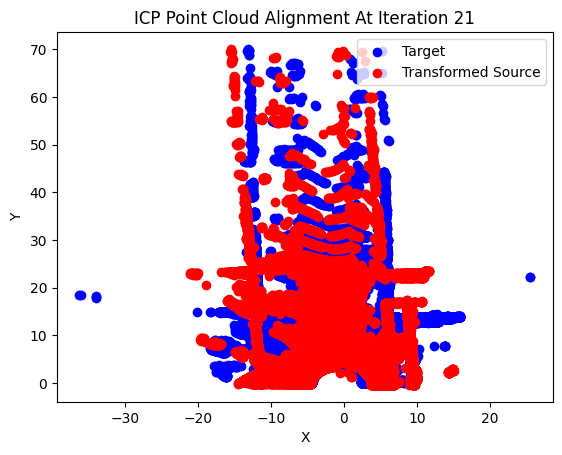

Frobenius Norm of the Difference: 9.458898923254559
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 13


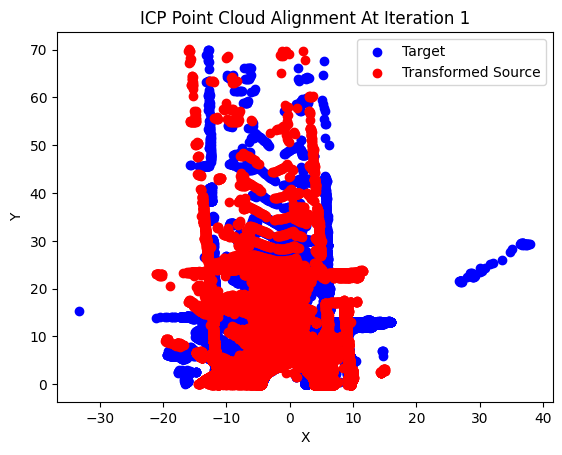

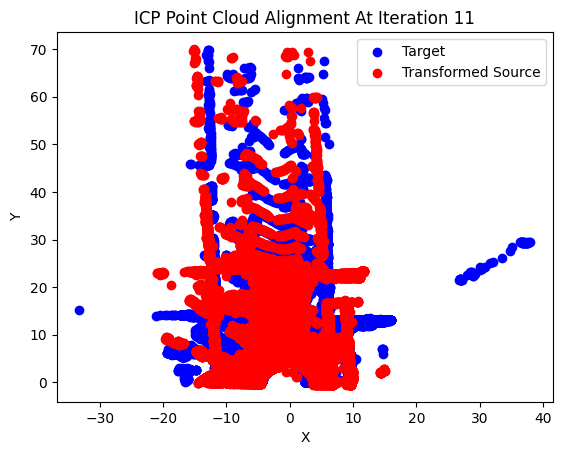

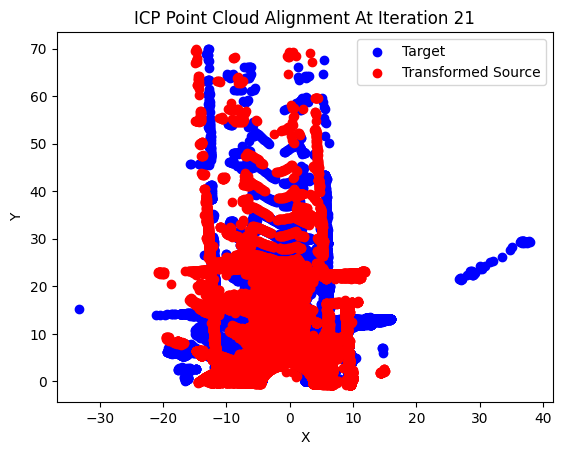

Frobenius Norm of the Difference: 10.319833484419332
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 14


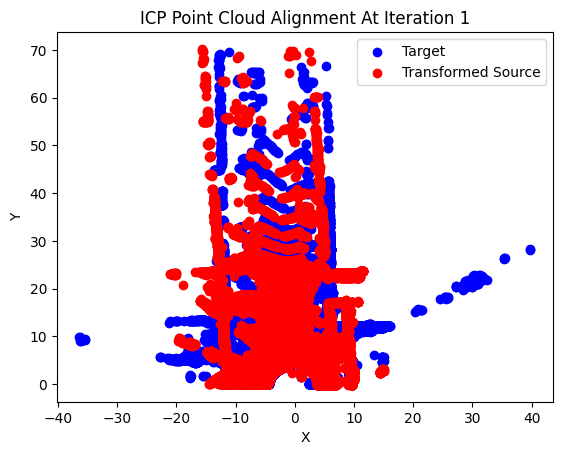

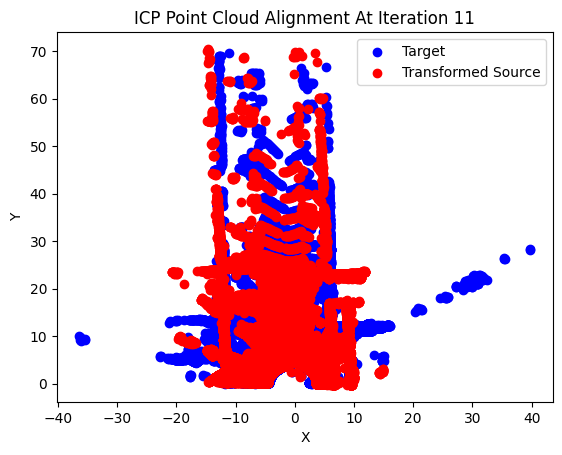

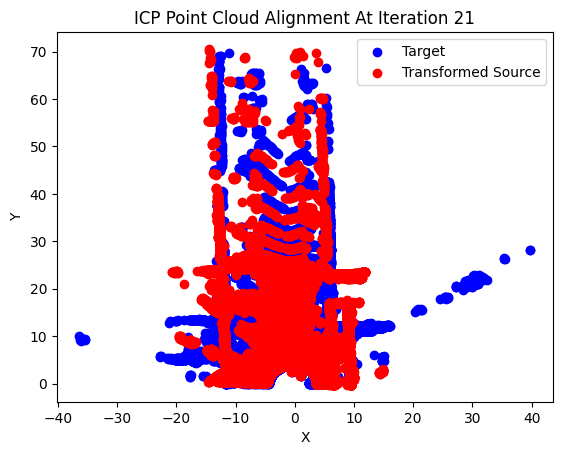

Frobenius Norm of the Difference: 11.18058613006443
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 15


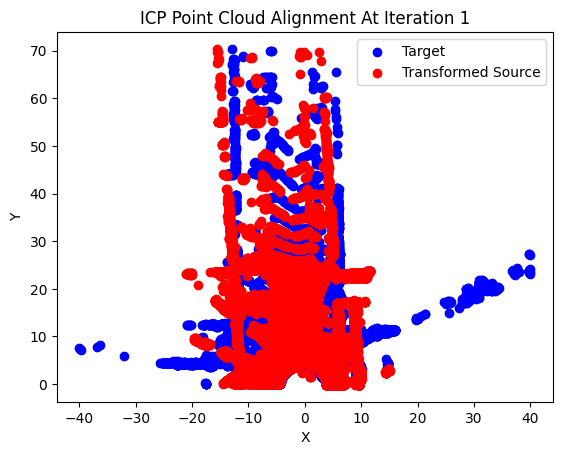

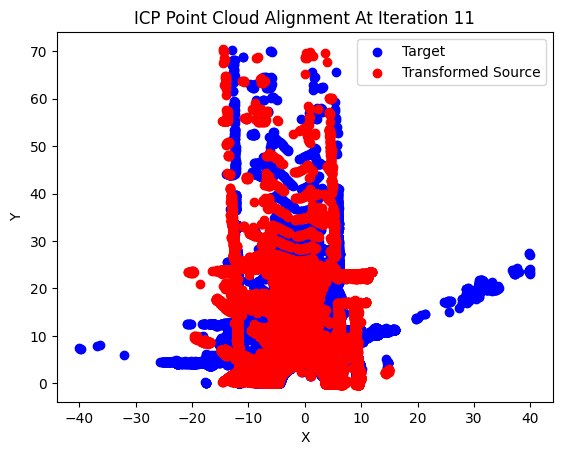

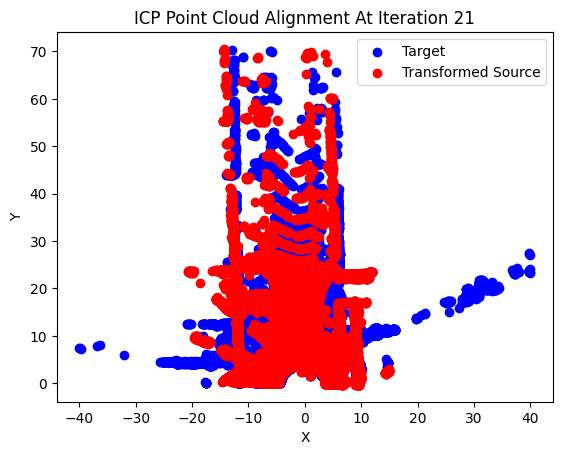

Frobenius Norm of the Difference: 12.040019718183608
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 16


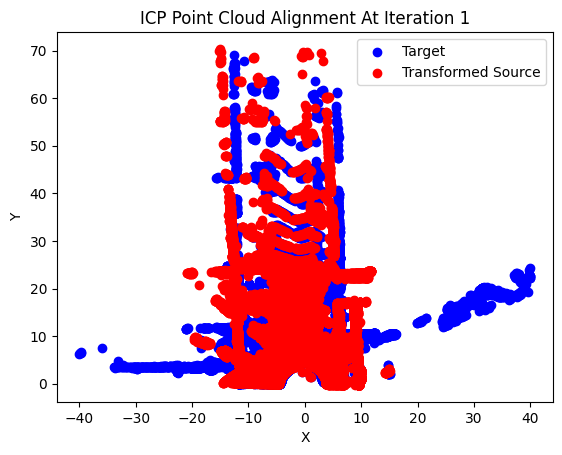

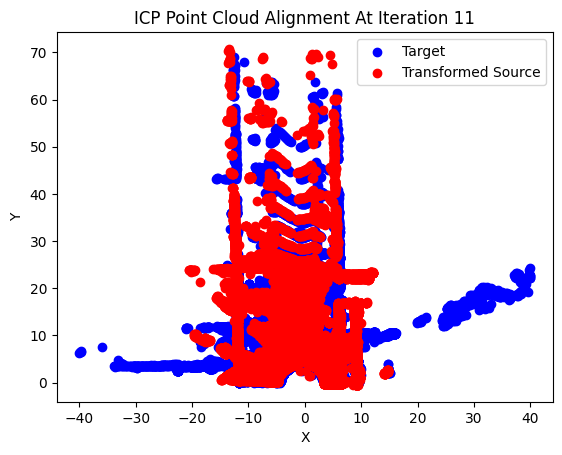

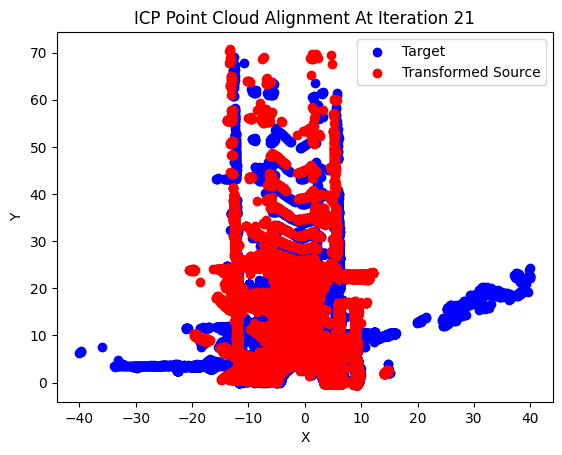

Frobenius Norm of the Difference: 12.895970534542258
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 17


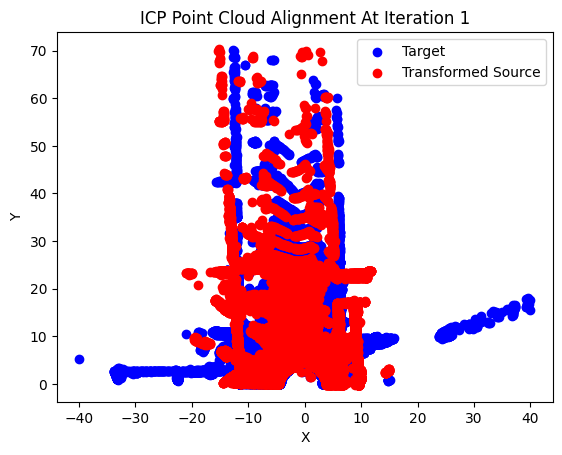

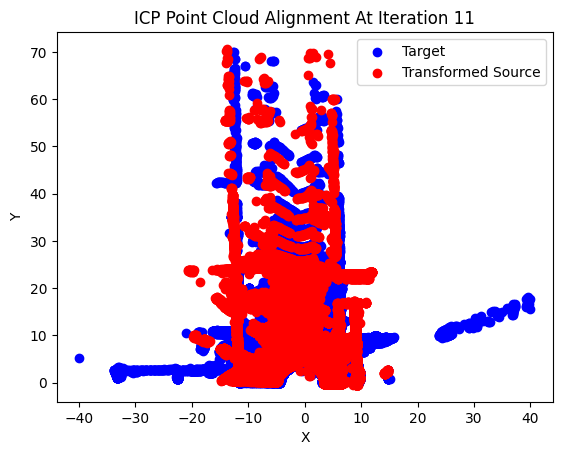

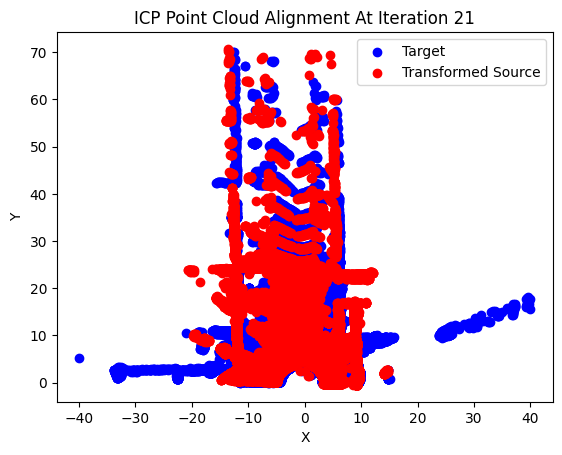

Frobenius Norm of the Difference: 13.759480024676606
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 18


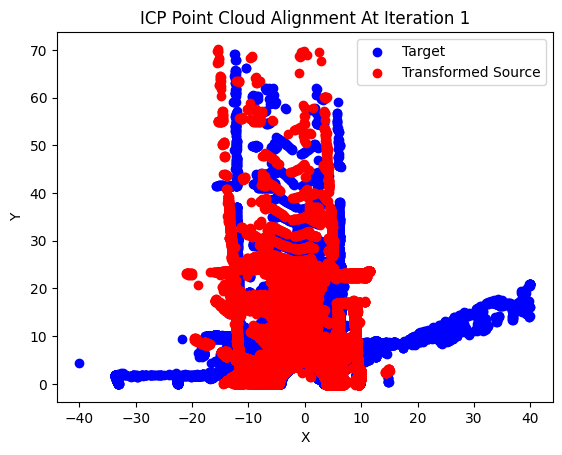

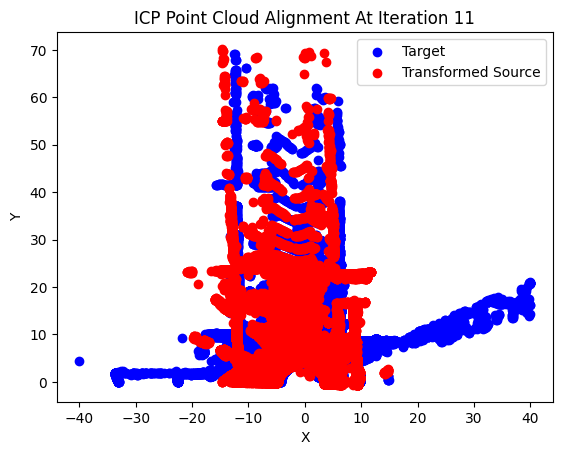

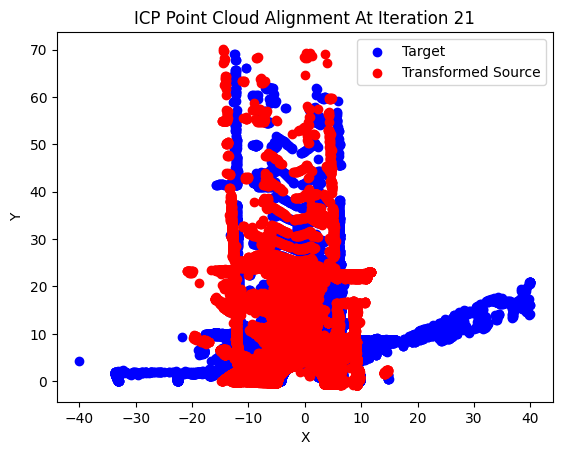

Frobenius Norm of the Difference: 14.629764735216318
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 19


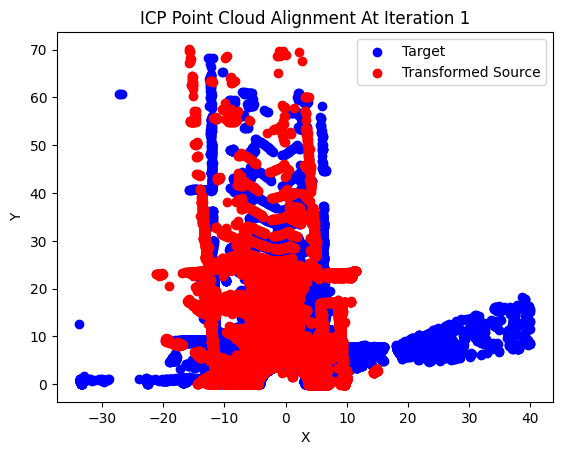

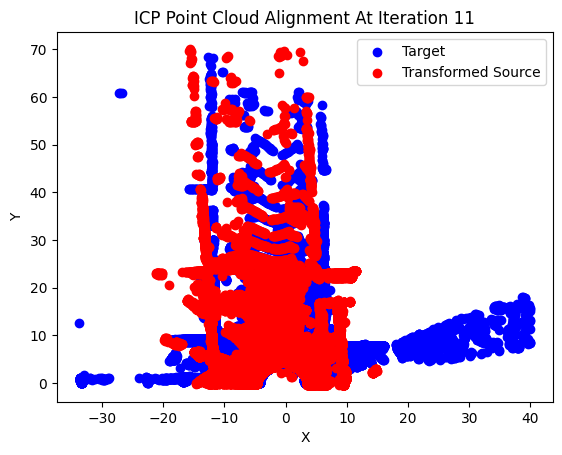

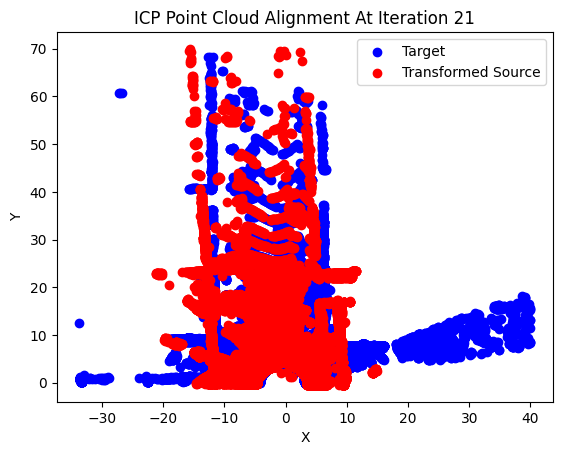

Frobenius Norm of the Difference: 15.510916964776946
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 20


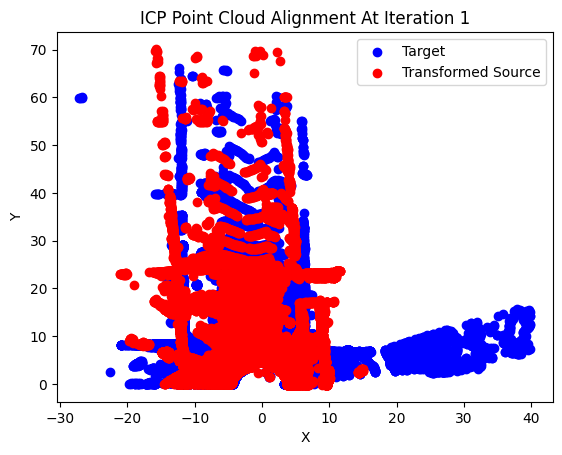

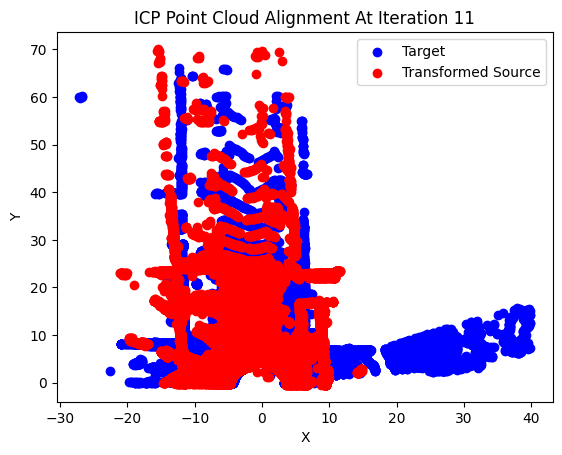

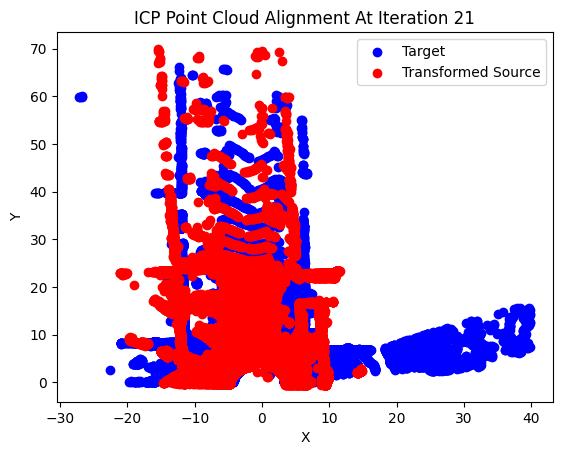

Frobenius Norm of the Difference: 16.403105540332074
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 21


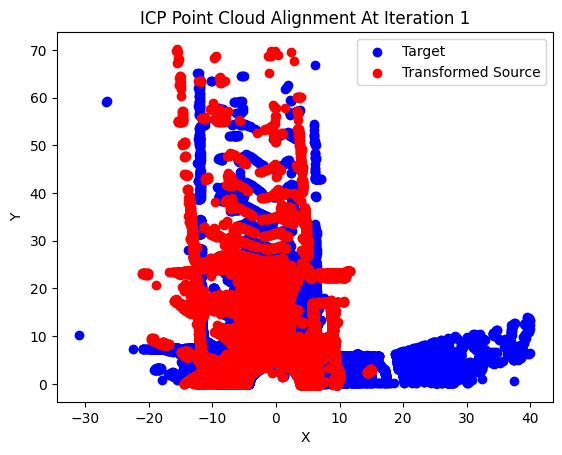

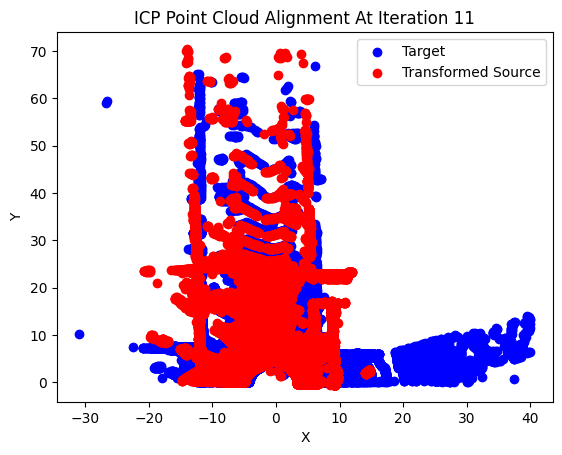

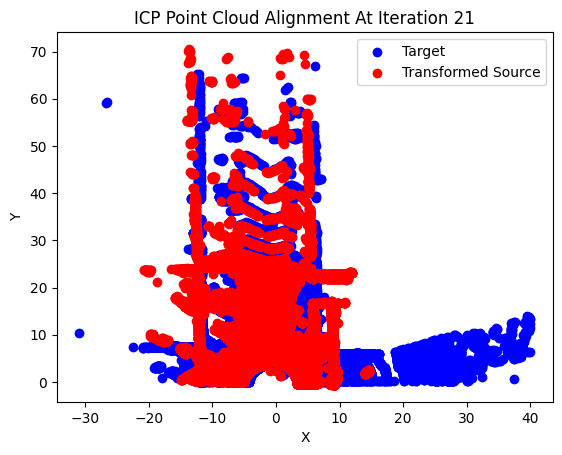

Frobenius Norm of the Difference: 17.305569132503518
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 22


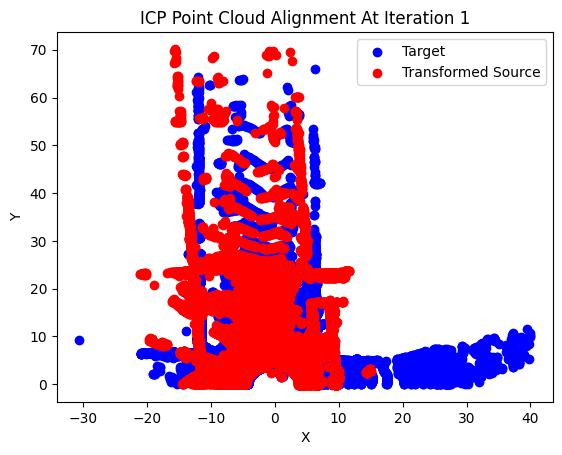

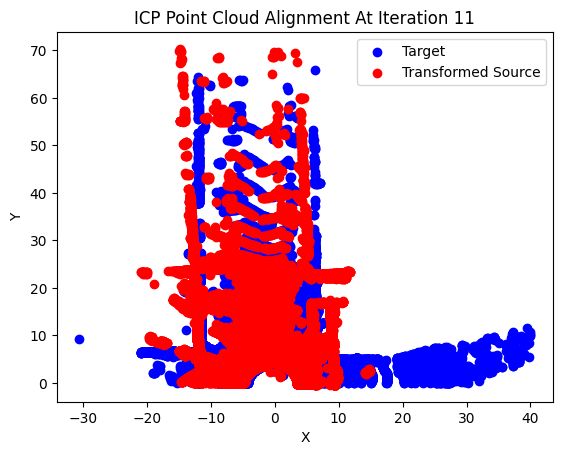

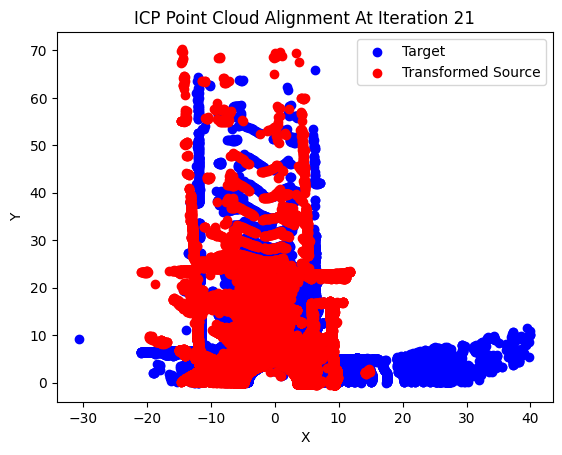

Frobenius Norm of the Difference: 18.211574834589033
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 23


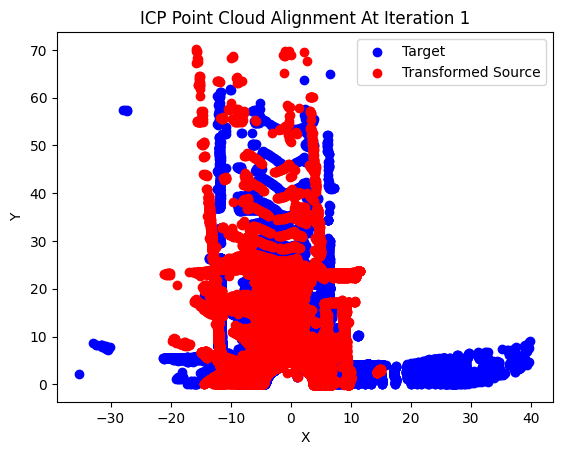

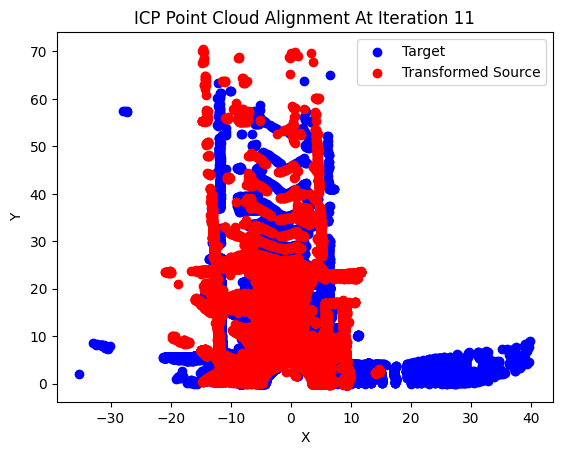

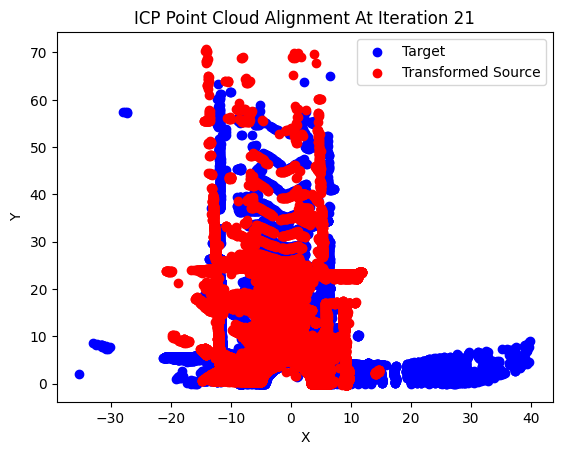

Frobenius Norm of the Difference: 19.124386716459895
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 24


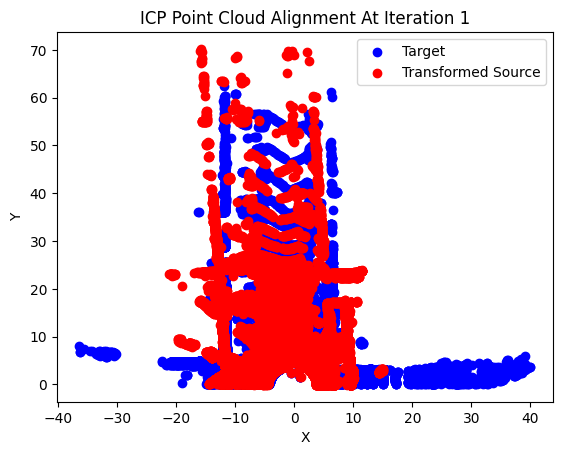

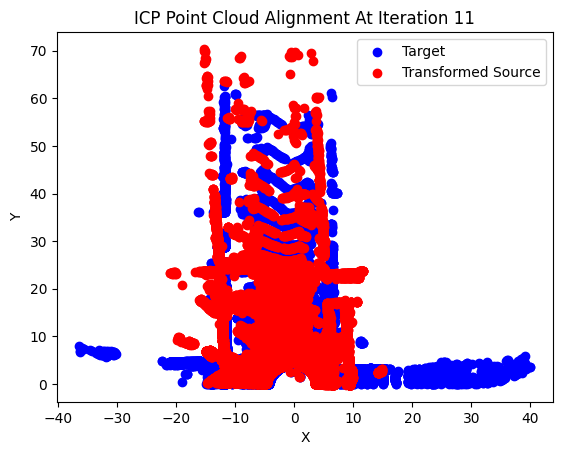

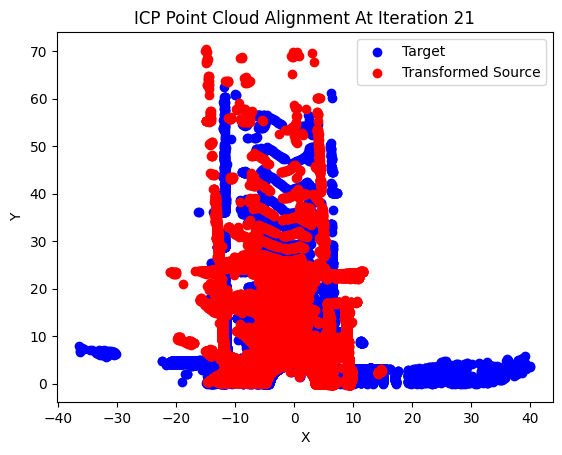

Frobenius Norm of the Difference: 20.04031740334646
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 25


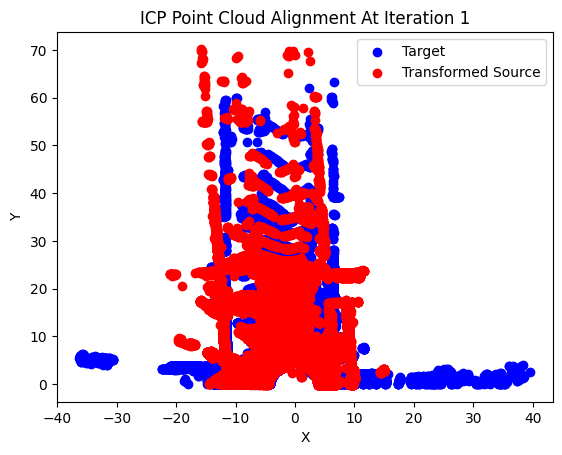

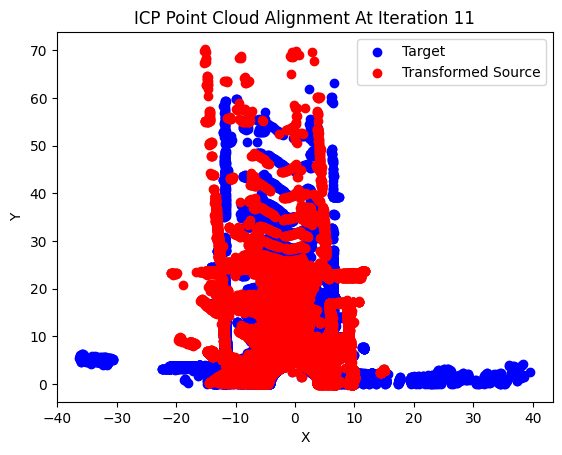

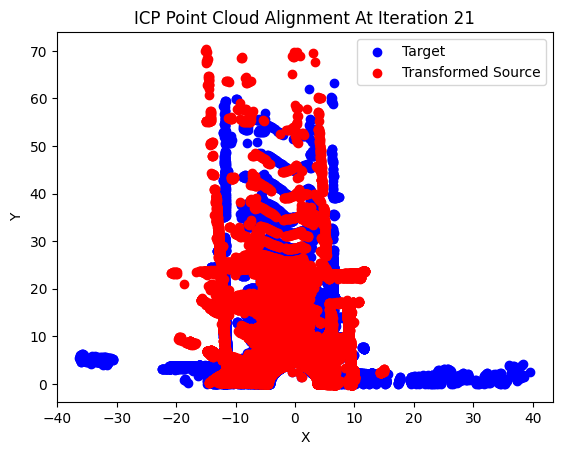

Frobenius Norm of the Difference: 20.95805701099981
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 26


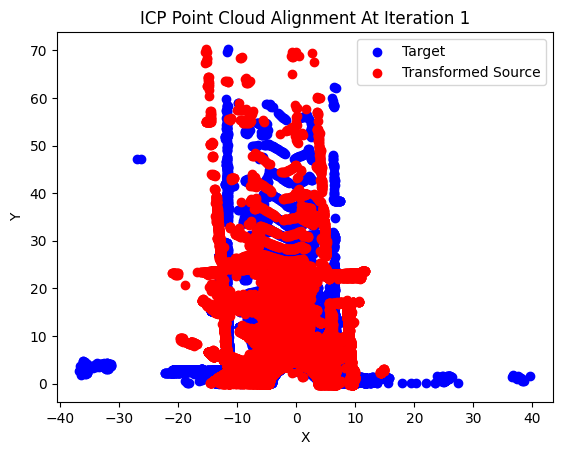

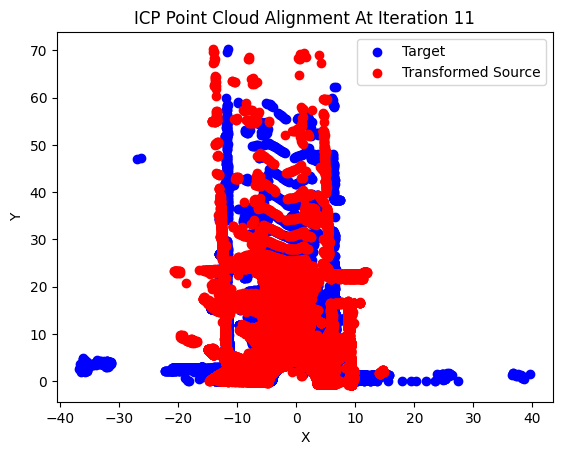

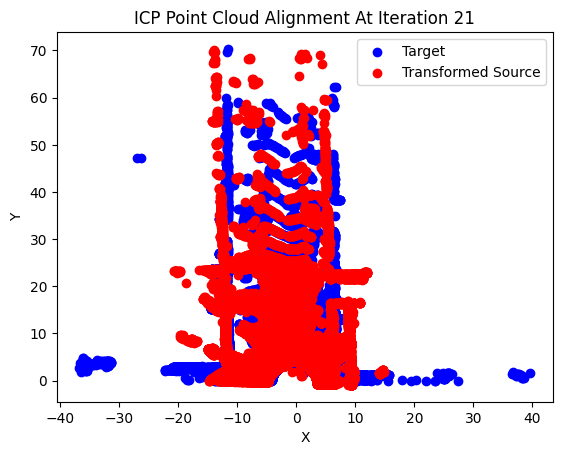

Frobenius Norm of the Difference: 21.887155041043496
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 27


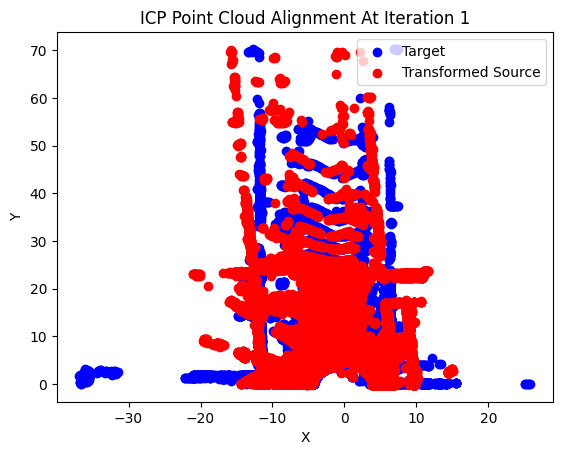

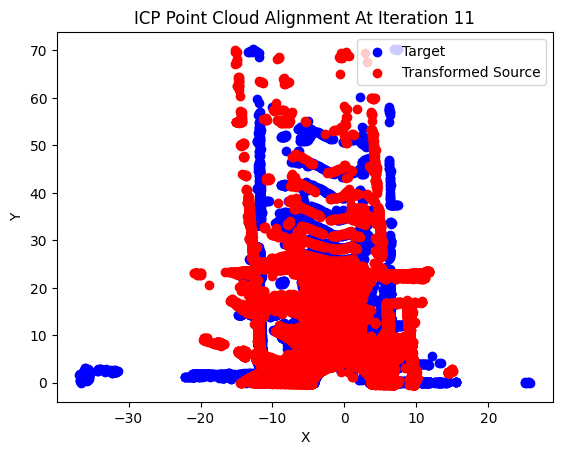

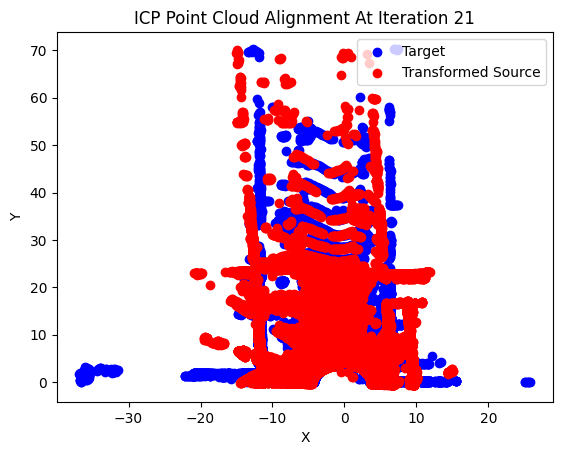

Frobenius Norm of the Difference: 22.823716183794442
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 28


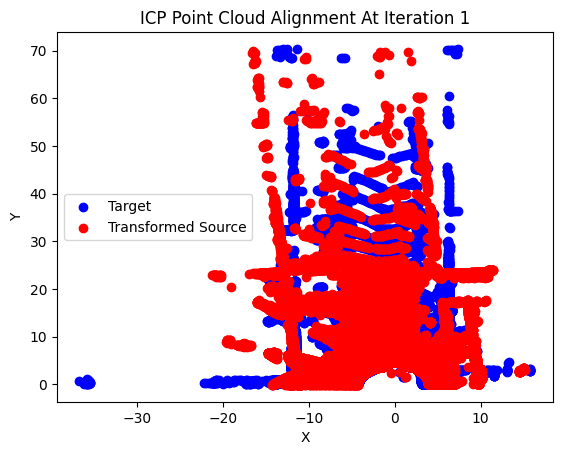

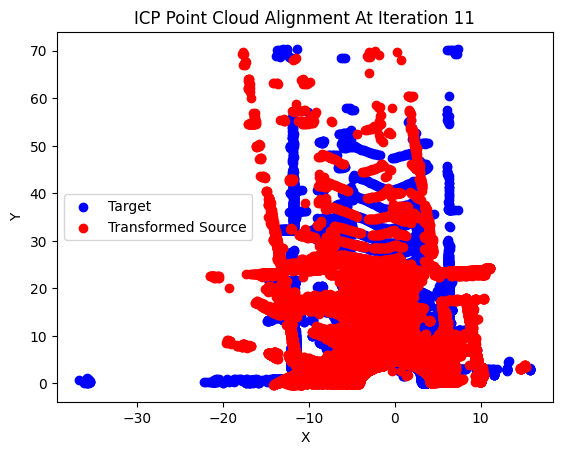

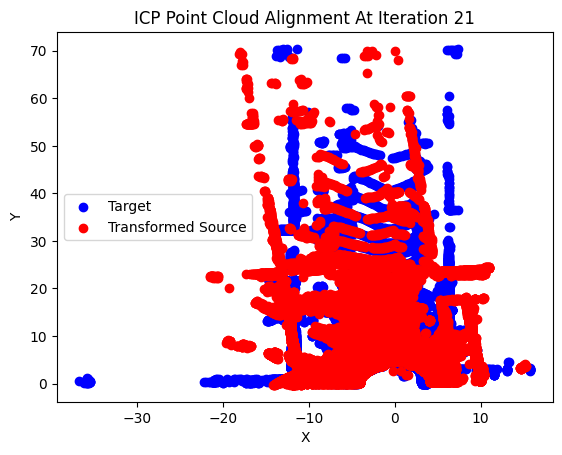

Frobenius Norm of the Difference: 23.760330552053215
-----------------------------------------------------------------------------------------------------------
Performing transform of number: 29


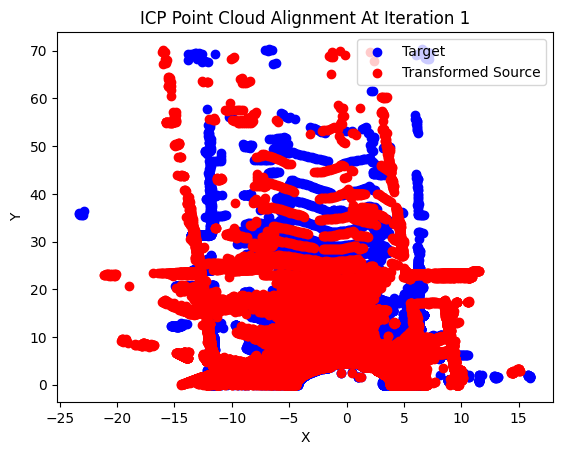

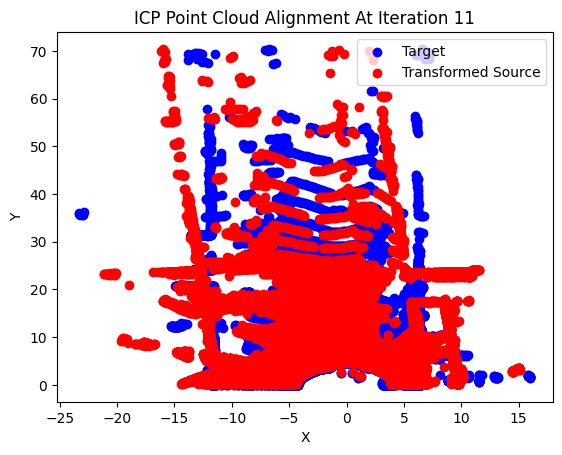

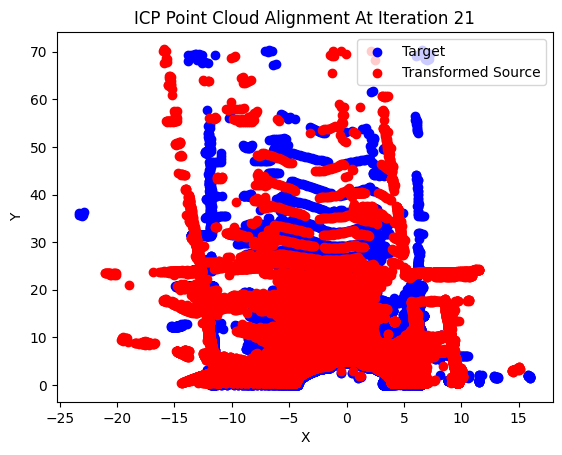

Frobenius Norm of the Difference: 24.704350529433736
-----------------------------------------------------------------------------------------------------------


In [9]:
# We use the first point cloud as the initial source, and align the subsequent point clouds
initial_source = point_clouds[0]
for i in range(1, len(point_clouds)):
    target = point_clouds[i]
    estimated_transformation = icp(initial_source, target, i)
    # Apply the estimated transformation to the source point cloud
    initial_source = np.dot(initial_source, estimated_transformation[:3, :3].T) + estimated_transformation[:3, 3]

    comparison_result = compare_transformations(estimated_transformation, ground_truth[i-1])
    print("Frobenius Norm of the Difference:", comparison_result)
    print("-----------------------------------------------------------------------------------------------------------")

Our code performed point cloud registration using the Iterative Closest Point (ICP) algorithm and compared the estimated transformations with ground truth transformations. That way, the last transformation (estimated_transformation) estimates the final trajectory of our vehicle. 

To get the final trajectory, you just need to print the "estimated_transformation" variable, which gives you the last transformation regarding the manipulations that occurs from the first position.

In [52]:
estimated_transformation

array([[ 9.99999975e-01,  2.15253057e-04, -5.35112332e-05,
        -6.69191172e-04],
       [-2.15253569e-04,  9.99999977e-01, -9.56263887e-06,
         1.44808490e-02],
       [ 5.35091736e-05,  9.57415712e-06,  9.99999999e-01,
         4.96482015e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

### Question 2

For this task, we want use a pre-trained model (on the resnet50 architecture) and fine-tune it to our data that contains a certain amount of celebs. Once the model is trained, we create a database containing the images, as well as the output vector of our model. We also store the celebrities' names, so we can make sense of the vector outputs.

In [37]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random

In [38]:
# Check if CUDA (GPU) is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
# Print our device
print(device)

cuda


First, we define the architecture of the neural network for generating descriptors.

In [40]:
# Definir a arquitetura da rede neural
class DescriptorNet(nn.Module):
    # Constructor
    def __init__(self, feature_dim):
        super(DescriptorNet, self).__init__()
        # Use a pretrained ResNet-50 model as the backbone
        self.backbone = models.resnet50(weights=True)
        # Modify the fully connected layer to output feature_dim-dimensional descriptors
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, feature_dim)

    # Forward pass
    def forward(self, x):
        return self.backbone(x)

To manipulate our data, we define a custom dataset for the celebrity instances.

In [41]:
class CelebDataset(Dataset):
    # Constructor
    def __init__(self, data_path, transform=None):
        self.data = []
        self.labels = []
        self.celeb_names = []  # Store celebrity names
        self.transform = transform
        # Iterate through celeb folders in the data_path
        celeb_folders = os.listdir(data_path)
        for label, celeb_folder in enumerate(celeb_folders):
            celeb_path = os.path.join(data_path, celeb_folder)
            if os.path.isdir(celeb_path):
                celeb_name = celeb_folder  # Use the folder name as the celeb name
                # Iterate through images in the celeb folder
                for image_name in os.listdir(celeb_path):
                    image_path = os.path.join(celeb_path, image_name)
                    self.data.append(image_path)
                    self.labels.append(label)
                    self.celeb_names.append(celeb_name)  # Store the celeb name

    # Return the length of the dataset                   
    def __len__(self):
        return len(self.data)

    # Retrieve an item from the dataset
    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        celeb_name = self.celeb_names[idx]  # Get the celeb name for the corresponding index
        # Open the image, apply transformations, and return the image, label, and celeb name
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, celeb_name

In [42]:
# Set the path to the CelebA data
data_path = 'post-processed/post-processed'

# Create a CelebDataset for training
train_dataset = CelebDataset(data_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]))

In [43]:
# Create a dataloader for training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [44]:
# Instantiate the descriptor model and optimizer
feature_dim = 128
model = DescriptorNet(feature_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [45]:
# Define the triplet margin loss and distance function
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
distance_fn = nn.PairwiseDistance()

(distance_fn não precisou ser usada no código - descartada)

In [46]:
# Training loop for the neural network
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in train_loader:
        images, labels, _ = batch
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # Generate anchor, positive, and negative indices for triplet loss
        anchor_indices, positive_indices, negative_indices = [], [], []
        for i in range(len(labels)):
            anchor_indices.append(i)

            # Find a positive sample with the same label (celebrity) as the anchor
            positive_mask = (labels == labels[i]).to('cpu').detach()
            positive_candidates = torch.arange(len(labels))[positive_mask]
            positive_indices.append(positive_candidates[torch.randint(len(positive_candidates), (1,))[0]])

            # Find a negative sample with a different label from the anchor
            negative_candidates = torch.arange(len(labels))[~positive_mask]
            negative_indices.append(negative_candidates[torch.randint(len(negative_candidates), (1,))[0]])

        # Extract anchor, positive, and negative descriptors
        anchor_outputs = outputs[anchor_indices]
        positive_outputs = outputs[positive_indices]
        negative_outputs = outputs[negative_indices]

        # Calculate triplet loss and perform backpropagation
        loss = criterion(anchor_outputs, positive_outputs, negative_outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        
    # Print the average loss for the epoch
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.0049
Epoch [2/10], Loss: 0.0043
Epoch [3/10], Loss: 0.0029
Epoch [4/10], Loss: 0.0030
Epoch [5/10], Loss: 0.0045
Epoch [6/10], Loss: 0.0035
Epoch [7/10], Loss: 0.0022
Epoch [8/10], Loss: 0.0026
Epoch [9/10], Loss: 0.0026
Epoch [10/10], Loss: 0.0021


Regarding reproductibility and time management, we store the trained our trained model: 'model'.

In [47]:
# Save the trained model
torch.save(model.state_dict(), 'celeb_model.pth')

In [48]:
model.eval()

# Dictionary to store descriptors for each celebrity
celeb_descriptors = {}

# Loop through the images in the dataset and generate descriptors
with torch.no_grad():
    for batch in train_loader:  # Assuming train_loader is the dataloader for the dataset
        images, labels, celeb_names = batch
        images = images.to(device)
        labels = labels.to(device)
        descriptors = model(images)  # Pass images through the model to get descriptors
        
        # Store descriptors in the celeb_descriptors dictionary
        for i, label in enumerate(labels):
            celeb_name = train_dataset.celeb_names[label]
            if celeb_name not in celeb_descriptors:
                celeb_descriptors[celeb_name] = []
            celeb_descriptors[celeb_name].append(descriptors[i].to('cpu').detach().numpy())

# Now you have a dictionary 'celeb_descriptors' containing descriptors for each celebrity
# Save the celeb_descriptors dictionary to a file
import pickle
with open('celeb_descriptors.pkl', 'wb') as f:
    pickle.dump(celeb_descriptors, f)

In [49]:
# Load the trained model
model.load_state_dict(torch.load('celeb_model.pth'))
model = model.to('cpu')

In [50]:
model.eval()

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the previously created celeb_descriptors dictionary
import pickle
with open('celeb_descriptors.pkl', 'rb') as f:
    celeb_descriptors = pickle.load(f)

# We now use a new image of the same person to be added to the database
new_image_path = 'post-processed/marcelinho/marcelinho_no_db.jpg'
new_image = Image.open(new_image_path).convert("RGB")
new_image = transform(new_image).unsqueeze(0)  # Convert to tensor and add batch dimension
with torch.no_grad():
    new_descriptor = model(new_image)  # Pass the new image through the model to get the descriptor

# Add the new descriptor to the celeb_descriptors dictionary
celeb_name = 'Marcelinho'  # Specify the name of the person
if celeb_name not in celeb_descriptors:
    celeb_descriptors[celeb_name] = []
celeb_descriptors[celeb_name].append(new_descriptor.numpy())

# Now, we use the model to classify a second photo of the same person
second_image_path = 'post-processed/marcelinho/marcelinho_na_inferencia.jpg'
second_image = Image.open(second_image_path).convert("RGB")
second_image = transform(second_image).unsqueeze(0)  # Convert to tensor and add batch dimension
with torch.no_grad():
    second_descriptor = model(second_image)  # Pass the second image through the model to get the descriptor

# Compare the descriptor of the second image with the stored descriptors
distances = []
for celeb_name, celeb_descriptor_list in celeb_descriptors.items():
    for celeb_descriptor in celeb_descriptor_list:
        distance = np.linalg.norm(second_descriptor - celeb_descriptor)
        distances.append((celeb_name, distance))

# Find the recognized celebrity with the smallest distance
recognized_celeb = min(distances, key=lambda x: x[1])[0]
print(f"Recognized celebrity: {recognized_celeb}")

Recognized celebrity: Dick_Armey


To summarize, the code above demonstrates the entire process, including loading the celebrity dataset, training a descriptor model, creating a database of celebrity descriptors, adding a new image to the database, and using the trained model to recognize a second photo of the same person based on the descriptors.